In [1]:
# importing dependencies
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize,sent_tokenize
import string
import operator
import math
import string
from matplotlib import pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import Birch
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pikepdf

%matplotlib inline

/home/developer/.local/lib/python3.5/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
def viz_clusters(X, labels):
    """
    Takes in the datapoints and the cluster labels and then construcs a scatterplot indicatiing  each custer 
    """
    X = np.array(X)
    plt.scatter(X[:,1], X[:,0], c=labels)
    plt.show()
    
def viz_clusters_after(X, labels):
    labels =list(set(X))
    plt.plot(X[:,1], X[:,0], c=labels)
    
def draw_table(norm_X,mean,closest):
    count = 0
    sentences = []
    for i in range(len(mean)):
        sentences_with_label = [sent[1] for sent in norm_X if sent[0] == mean[i][0]]
        for sent in sentences_with_label:
            sentence_row = (count,sent,mean[i][0],mean[i][1],closest[i][1])
            sentences.append(sentence_row)
            count +=1
    return np.array(sentences)

In [3]:
def set_threshold(sentences):
    return int(0.5 * len(sentences))


In [4]:
# 1.0  SENTENCE PREPROCESSING
def preprocess(words):
    stp = stopwords.words('english')
    white_list = ['Allah', 'God']
    words = [word for word in words if word not in stp]
    words = [word for word in words if word not in string.punctuation]
    words = [word.lower() for word in words]
    return words

def lemmatize(sentence):
    wnl = WordNetLemmatizer()
    lemmed_words = []
    for word in word_tokenize(sentence):
        wrd = wnl.lemmatize(word)
        lemmed_words.append(wrd)
    return lemmed_words

def tagger(sentence):
    """
    takes a whole sentence as input and gets the Part-Of-Speech tag for each word in the sentence
    """
    acceptable_words = []
    word_tags = pos_tag(sentence)
    print(word_tags)
    for word_tag in word_tags:
        if (word_tag[1] == "NP" or word_tag[1] == "VP"):
            acceptable_words.append(word_tag[0])
    return acceptable_words


In [5]:
# 2.0 CLUSTERING

def cluster_sentences(document, sentences):
    X = vectorize(document)
    bcl = Birch(branching_factor=10, n_clusters=None, threshold=0.3).fit(X) # the algorithm figures out the clusters
    clusters = bcl.predict(X)
    labels = bcl.labels_
    norm_X = normalize_vector(X, labels)
    viz_clusters(norm_X,labels) # visualization before finding the mean
    cluster_means = calculate_mean(norm_X)
    cluster_sentences = find_minimum_from_mean(cluster_means, norm_X)
#     viz_clusters_after(cluster_sentences, set(labels)) # visualization after finding the closest to mean
    sents = vectors_to_sentences(cluster_sentences, norm_X, sentences)
    sentence_data = draw_table(norm_X,cluster_means,cluster_sentences)
    sentence_data = pd.DataFrame(sentence_data, columns = ['Sentence', 'Vector_Value', ' Cluster_ID', 'Cluster_Mean', 'Closest_Sentence_Vector'])
    return sents, sentence_data

def calculate_mean(X):
    clusters = set([sent[0] for sent in X ])
    cluster_mean = []
    for cluster in clusters:
        cluster_value = 0
        count = 0
        for i,element in enumerate(X):
            if (cluster == element[0]):
                cluster_value += element[1]
                count += 1
        mean_cluster_value = cluster_value/count
        cluster_mean.append([cluster,mean_cluster_value])
    print("Cluster Means:")
    print(cluster_mean)
    return cluster_mean

def find_minimum_from_mean(cluster_means, vectorized):
    """
    This function computes the minimal distance between each element in X and the elements in Y
    cluster_means : A 2D array
    points : A 2D array consisting of cluster type and the corresponding value

    It returns an array which consist of point in X and the corresponding point in Y with the smallest distance the point in X

    """
    minimal_distances = []
    for clm in cluster_means:
        points_in_cluster = [v[1] for v in vectorized if v[0] == clm[0]]
        minimal = points_in_cluster[0]
        for pt in points_in_cluster:
            diff_current = abs(clm[1] - pt) 
            diff_minimal = clm[1] - minimal
            if (diff_current < diff_minimal):
                  minimal = pt
        minimal_distances.append((clm[0],minimal))
    print("Minimal", minimal_distances)
    return minimal_distances

def normalize_vector(v, labels):
    vectorized = []
    for i in range(len(v)):
        mean = abs(sum(v[i]/len(v[i])))
        vectorized.append((labels[i],mean))
    return vectorized

def vectors_to_sentences(clustered_sentences, sentence_vector, sentences):
    print("Sentence Vectors == sentences")
    print(len(sentence_vector), len(sentences)) 
    index = 0
    selected_sentences = []
    top_sentences = [s[1] for s in clustered_sentences ]
    for v in sentence_vector:
        if v[1] in top_sentences:
            print(v[1])
            selected_sentences.append((index,sentences[index]))
        index +=1
    return selected_sentences

def vectorize(document):
    words = word_tokenize(document)
    words = preprocess(words)
    X = [TaggedDocument(word,[idnx]) for idnx,word in enumerate(words)]
    vectorizer = Doc2Vec(X, size=10)
    sentence_vectors = [vectorizer.infer_vector(word_tokenize(sen), alpha=2,steps=400) for sen in sent_tokenize(document)]
    return sentence_vectors


In [6]:
# 4.0 RANKING AND GENERATING THE FINAL SUMMARY
def generate_summary(sentences,scores,threshold):
        ranked_scores = sorted(scores, key=lambda sc:sc[1], reverse=True)
        summary = []
        for sent_rank in ranked_scores:
            summary.append((sent_rank[0], sentences[sent_rank[0]]))
        return summary

In [7]:
# SUMMARIZE DOCUMENT 
def summarizeDocument(document):
    """
    functions takes a document and returns its summary
    """
    sentences = sent_tokenize(document)
    threshold = set_threshold(sentences) 
    document = re.sub('\n', ' ', document)
    indexed_sentences, sentence_data = cluster_sentences(document, sentences) 
    summary = [sentence[1] for sentence in indexed_sentences]
    return summary, sentence_data

/home/developer/.local/lib/python3.5/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


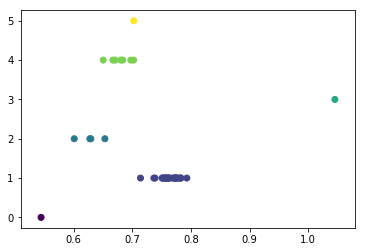

Cluster Means:
[[0, 0.5442608147859573], [1, 0.7635105145829064], [2, 0.6277379710227251], [3, 1.0456908997148275], [4, 0.6787973908441407], [5, 0.7025568783283234]]
Minimal [(0, 0.5442608147859573), (1, 0.7738337591290474), (2, 0.6275933235883713), (3, 1.0456908997148275), (4, 0.683555856347084), (5, 0.7025568783283234)]
Sentence Vectors == sentences
42 42
0.5442608147859573
0.7738337591290474
0.6275933235883713
1.0456908997148275
0.683555856347084
0.7025568783283234


'Text summarization is a branch of Natural Language Processing (NLP) which can be described as the process of creating a compressed representation of a text document which conveys the main ideas of the document (Tohalino & Amancio, 2017). Text summarization is an important field as the amount of textual data that different industries need to process keeps growing, (Bouscarrat, et al. Thus, text summarization as a tool, help in transforming these information in a smaller and easily digestible form. For a given document containing of a set of sentences S, the aim of extractive text summarization is to select top k sentences that covers the main idea expressed in that document (Nikolov, Pfieffer & Hahnloser, 2018). 1.3 Aim and Objectives of the Study\nThe aim of the study to is build and evaluate a text summarization model utilizing both supervised and unsupervised techniques. Although the model used for summarization performs single document summarization, the entire system can generate 

In [8]:
document = open('./raw_text/test__1.txt').read()
summary,sentence_data = summarizeDocument(document)
" ".join(summary)

In [18]:
file = open('./raw_text/summaries/summary1.txt', 'a')
file.write("".join(summary))

1040

In [16]:
help(open)

Help on built-in function open in module io:

open(file, mode='r', buffering=-1, encoding=None, errors=None, newline=None, closefd=True, opener=None)
    Open file and return a stream.  Raise IOError upon failure.
    
    file is either a text or byte string giving the name (and the path
    if the file isn't in the current working directory) of the file to
    be opened or an integer file descriptor of the file to be
    wrapped. (If a file descriptor is given, it is closed when the
    returned I/O object is closed, unless closefd is set to False.)
    
    mode is an optional string that specifies the mode in which the file
    is opened. It defaults to 'r' which means open for reading in text
    mode.  Other common values are 'w' for writing (truncating the file if
    it already exists), 'x' for creating and writing to a new file, and
    'a' for appending (which on some Unix systems, means that all writes
    append to the end of the file regardless of the current seek position